テストデータ

In [1]:
import torch_geometric
from torch_geometric.datasets import Planetoid, KarateClub
import matplotlib.pyplot as plt
import networkx as nx

# dataset = Planetoid('/tmp/Cora', name='Cora')
dataset = KarateClub()
data = dataset[0]

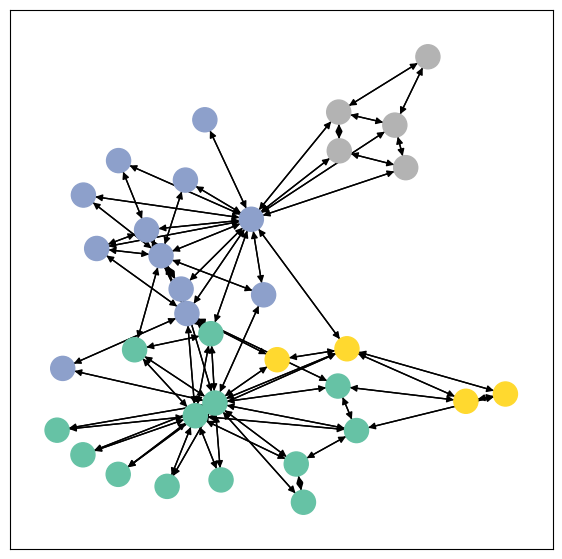

In [21]:
# 可視化

G = torch_geometric.utils.convert.to_networkx(data, to_undirected=False)

plt.figure(figsize=(7, 7))

pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos, with_labels=False, node_color=data.y, cmap="Set2")
plt.show()

Node2Vec

In [35]:
import torch
from torch_geometric.nn import Node2Vec

# GPUが利用可能な場合はGPUを使用し、そうでない場合はCPUを使用
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1.0,
    q=1.0,
    sparse=True,
).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=0)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [36]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(
        train_z=z[data.train_mask],
        train_y=data.y[data.train_mask],
        test_z=z[data.test_mask],
        test_y=data.y[data.test_mask],
        max_iter=150,
    )
    return acc

In [37]:
for epoch in range(1, 101):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

Epoch: 001, Loss: 8.1552, Acc: 0.1630
Epoch: 002, Loss: 6.0668, Acc: 0.1910
Epoch: 003, Loss: 4.9354, Acc: 0.2290
Epoch: 004, Loss: 4.1219, Acc: 0.2570
Epoch: 005, Loss: 3.4765, Acc: 0.2910
Epoch: 006, Loss: 2.9600, Acc: 0.3230
Epoch: 007, Loss: 2.5488, Acc: 0.3580
Epoch: 008, Loss: 2.2188, Acc: 0.3790
Epoch: 009, Loss: 1.9549, Acc: 0.4090
Epoch: 010, Loss: 1.7465, Acc: 0.4350
Epoch: 011, Loss: 1.5658, Acc: 0.4640
Epoch: 012, Loss: 1.4323, Acc: 0.4730
Epoch: 013, Loss: 1.3200, Acc: 0.4950
Epoch: 014, Loss: 1.2343, Acc: 0.5140
Epoch: 015, Loss: 1.1641, Acc: 0.5370
Epoch: 016, Loss: 1.1073, Acc: 0.5650
Epoch: 017, Loss: 1.0631, Acc: 0.5940
Epoch: 018, Loss: 1.0258, Acc: 0.6210
Epoch: 019, Loss: 0.9971, Acc: 0.6400
Epoch: 020, Loss: 0.9735, Acc: 0.6480
Epoch: 021, Loss: 0.9538, Acc: 0.6600
Epoch: 022, Loss: 0.9379, Acc: 0.6660
Epoch: 023, Loss: 0.9229, Acc: 0.6700
Epoch: 024, Loss: 0.9132, Acc: 0.6750
Epoch: 025, Loss: 0.9045, Acc: 0.6730
Epoch: 026, Loss: 0.8956, Acc: 0.6760
Epoch: 027, 

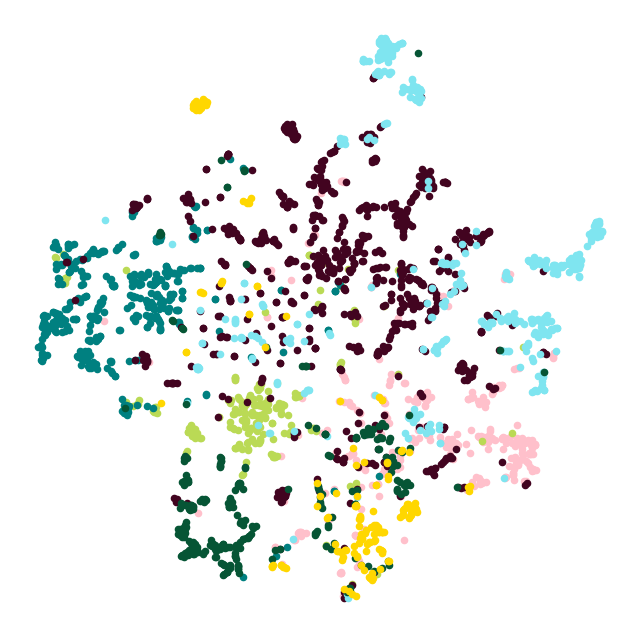

In [38]:
from sklearn.manifold import TSNE
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model().cpu().numpy()
    z = TSNE(n_components=2).fit_transform(z)
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()


colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)

kmeansでクラスタリングしてみる

In [45]:
from sklearn.cluster import KMeans

# 埋め込み表現
z = model()

# numpy配列に変換
z = z.to('cpu').detach().numpy()

kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(z)

KMeans(n_clusters=7, random_state=42)

In [46]:
kmeans.labels_

array([6, 6, 6, ..., 0, 6, 6])

In [47]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

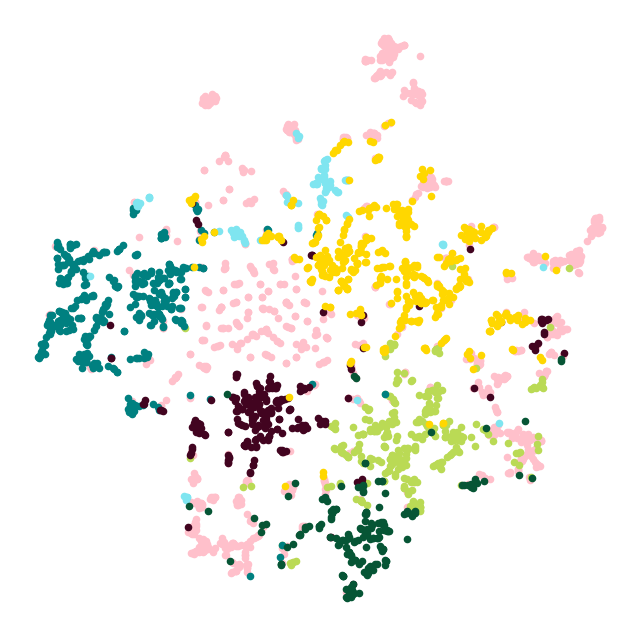

In [48]:
# 分類を可視化
# 上の画像は正解の分類
# 色自体は違う
from sklearn.manifold import TSNE
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model().cpu().numpy()
    z = TSNE(n_components=2).fit_transform(z)
    y = kmeans.labels_

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()


colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)